In [ ]:
!git clone https://github.com/pytorch/vision.git
!cp /content/vision/references/detection/*.py /content

Cloning into 'vision'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 9483 (delta 9), reused 5 (delta 0), pack-reused 9456
Receiving objects: 100% (9483/9483), 11.34 MiB | 18.14 MiB/s, done.
Resolving deltas: 100% (6573/6573), done.


In [4]:
import json
import cv2
import glob 
import os
import matplotlib.pyplot as plt

image=[]
obj=[]
  

for i,name in enumerate(glob.glob('/content/drive/My Drive/labels2/*.png')): 
  if os.path.exists(name+"___objects.json"):
    with open(name+'___objects.json') as f:
      obj.append( json.load(f))
    image.append(cv2.imread(name))
    #obj.append(name+"___objects.json")
  else:
    print(False)
  print(i,name) 

False
0 /content/drive/My Drive/labels2/04-24-2018_15-37-16.088_Top_126.png
1 /content/drive/My Drive/labels2/04-24-2018_15-37-10.281_Top_117.png
False
2 /content/drive/My Drive/labels2/04-24-2018_15-37-14.796_Top_124.png
3 /content/drive/My Drive/labels2/04-24-2018_15-37-04.750_Top_109.png
False
4 /content/drive/My Drive/labels2/04-24-2018_15-37-16.718_Top_127.png
5 /content/drive/My Drive/labels2/04-24-2018_15-37-15.137_Top_125.png
6 /content/drive/My Drive/labels2/04-24-2018_15-37-12.538_Top_121.png
False
7 /content/drive/My Drive/labels2/04-24-2018_15-37-17.038_Top_128.png
8 /content/drive/My Drive/labels2/04-24-2018_15-37-06.042_Top_111.png
9 /content/drive/My Drive/labels2/04-24-2018_15-37-09.299_Top_116.png
10 /content/drive/My Drive/labels2/04-24-2018_15-37-13.824_Top_123.png
11 /content/drive/My Drive/labels2/04-24-2018_15-37-10.932_Top_118.png
12 /content/drive/My Drive/labels2/04-24-2018_15-37-08.971_Top_115.png
13 /content/drive/My Drive/labels2/04-24-2018_15-37-05.722_Top_

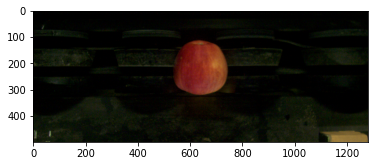

In [5]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))

In [6]:
import torchvision.transforms as T
import torch 
import numpy as np

class AppleDataset(object):
    def __init__(self, obj,images):
        
        self.dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
        self.to_tensor = T.ToTensor()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.obj = obj
        self.images=images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        vis={'True':1,'False':0}
        pts=[]
        boxes=[]
        for i in self.obj[idx]:
          if i['type']=='point':
            pts.append(i['x'])
            pts.append(i['y'])
            pts.append(1)
          elif i['type']=='bbox':
            boxes.append([i['points']['x1'],i['points']['y1'],i['points']['x2'],i['points']['y2']])

         
        image =self.images[idx]
        #kpts = np.array(self.df.iloc[idx, 1:]).astype(np.float32).reshape([-1, 3]) # [x, y, visibility]
        kpts=np.array(pts).astype(np.float32).reshape([1,-1,3])#considering one apple per imageyzyy
        boxes=np.array(boxes).astype(np.float32)
        h, w = image.shape[:2]
        
        if w < 640:
            image = imutils.resize(image, width=640)
        
        labels = np.ones((1), dtype=np.int8)
        image_id = torch.tensor([idx])
        target = {}
        target["boxes"] = torch.from_numpy(boxes).type(self.dtype).to(self.device)
        target["labels"] = torch.from_numpy(labels).type(torch.int64).to(self.device)
        target["keypoints"] = torch.from_numpy(kpts).type(self.dtype).to(self.device)
        target["image_id"] = image_id.to(self.device)
        #target["area"] =(torch.tensor(boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])).to(self.device) 
        iscrowd = torch.zeros((1,), dtype=torch.int64)#one apple per image
        target["iscrowd"] = iscrowd.to(self.device)
        img = T.ToPILImage()(image).convert('RGB')
        img = self.to_tensor(img).to(self.device)        

        return img, target

In [7]:
print(torch.cuda.is_available(),
torch.cuda.get_device_capability(),
torch.cuda.device_count(),
torch.cuda.get_device_name(device=None))

True (3, 7) 1 Tesla K80


In [8]:
Dataset = AppleDataset(obj, image)

l=Dataset.__len__()
test_percent=5
torch.manual_seed(1)
indices = torch.randperm(len(Dataset)).tolist()
dataset = torch.utils.data.Subset(Dataset, indices[:-int(np.ceil(l*test_percent/100))])
dataset_test = torch.utils.data.Subset(Dataset, indices[int(-np.ceil(l*test_percent/100)):])

In [9]:
print(dataset.__len__(),dataset_test.__len__())

200 11


In [10]:
# define training and validation data loaders
import utils
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, 
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=(1), shuffle=False, 
    collate_fn=utils.collate_fn)

In [11]:
import torch
import torchvision
import torch.nn as nn
def get_model(num_kpts,train_kptHead=False,train_fpn=True):
    is_available = torch.cuda.is_available()
    device =torch.device('cuda:0' if is_available else 'cpu')
    dtype = torch.cuda.FloatTensor if is_available else torch.FloatTensor
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
    
    for i,param in enumerate(model.parameters()):
        param.requires_grad = False
        
    if train_kptHead!=False:
      for i, param in enumerate(model.roi_heads.keypoint_head.parameters()):
          if i/2>=model.roi_heads.keypoint_head.__len__()/2-train_kptHead:
            param.requires_grad = True

    if train_fpn==True:
      for param in model.backbone.fpn.parameters():
        param.requires_grad = True

    out = nn.ConvTranspose2d(512, num_kpts, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    model.roi_heads.keypoint_predictor.kps_score_lowres = out
    
    return model, device, dtype
#model, device, dtype=get_model(2)

In [12]:
#load a pretrained model
from google.colab import files
model_save_name = 'classifier3.pth'
path = F"/content/drive/My Drive/{model_save_name}" 
model, device, dtype=get_model(2,train_kptHead=2,train_fpn=True)
model.to(device)
model.load_state_dict(torch.load(path))
#torch.save(model.state_dict(), path)

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


<All keys matched successfully>

In [13]:
from PIL import Image
import numpy
from google.colab import files

def show_result(data,no_images=50):

  figsize=(500, 1280)
  columns = 1
  rows = 50
  fig=plt.figure()
  j=0
  for i,(image,keypoints) in enumerate(data):
   
    image=image.cpu().permute(1, 2, 0).numpy()
    image=image[:, :, [2, 1, 0]]  
    cX1=int(keypoints['keypoints'][0][0][0])
    cY1=int(keypoints['keypoints'][0][0][1])
    cX=int(keypoints['keypoints'][0][1][0])
    cY=int(keypoints['keypoints'][0][1][1])
    im = Image.fromarray(np.uint8((image)*255))
    image=np.asarray(im)
    cv2.line(image, (cX, cY), (cX1, cY1), (256,0,0), 10)
    cv2.circle(image, (cX, cY), 10, (255, 0, 0))
    cv2.circle(image, (cX1, cY1), 10, (0, 255, 255))
    plt.imshow(image)
    
    #im = Image.fromarray(image)
    #im.save("test_out{}.jpeg".format(j))
    #files.download("test_out{}.jpeg".format(j))
  plt.show()


In [14]:

image_test=(cv2.imread("/content/04-24-2018_15-32-29.426_Top_64.png"))
image_test=T.ToPILImage()(image_test).convert('RGB')
image_test= T.ToTensor()(image_test).to(torch.device('cuda:0'))
image_test=[image_test]
model.eval()
out=model(image_test)




show_result( zip(image_test,out))
image_test[0].shape

TypeError: ignored

In [ ]:
torch.__version__

In [ ]:
import torch.onnx
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
#Image=torch.tensor(Dataset[0][0].unsqueeze(dim=0),device=torch.device('cuda:0'))
model.eval()
out = model(image_test)
dynamic_axes = {'input': [0, 2, 3], 'output': [0, 2, 3]}
# Export the model
torch.onnx.export(model,                     # model being run
                  image_test,                # model input (or a tuple for multiple inputs)
                  "apple_axis.onnx",         # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes=dynamic_axes)

In [ ]:
num_classes = 2
num_kpts=2
# get the model using our helper function
model, device, dtype=get_model(num_kpts,train_kptHead=2,train_fpn=True)
# move model to the right device
model.to(device)

# construct an optimizer

params1 = [p for p in model.roi_heads.keypoint_head.parameters() if p.requires_grad]

params2 = [p for p in model.backbone.fpn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD([
                {'params': params1},
                {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .1},
                {'params': params2, 'lr': .001}
            ], lr=.005, momentum=0.9)
"""
optim.SGD([
                {'params': model.roi_heads.keypoint_head.parameters()},
                {'params': model.roi_heads.keypoint_predictor.parameters(), 'lr': .1}
            ], lr=.005, momentum=0.9)
"""
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.95)
print(params.__len__())
for name,param in model.named_parameters():
  if ( param.requires_grad ==True):
    print(name)

In [ ]:
from engine import train_one_epoch, evaluate

num_epochs = 50

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

In [ ]:
#save model
model_save_name = 'classifier4.pth'
path = F"/content/drive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
for names,param in model.named_parameters():
  print (param.device)

print(image_test)

In [ ]:
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
model.eval()
output = model(images)   # Returns losses and detections
output.__len__()


to download the model

In [ ]:
"""
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')
"""

In [ ]:
for images,targets in (iter(data_loader_test)):
  images = list(image for image in images)
  #targets = [{k: v for k, v in t.items()} for t in targets]
  model.eval()
  outputs = model(images)

  show_result( zip(images,outputs))
  """
  for image, output in zip(images,outputs):
    image_idx=0
    kpt_idx=0
    show_result(image,output['keypoints'][kpt_idx])
  """